## Лабораторная работа №1: Исследование алгоритма K-Nearest Neighbors (KNN)
Выполнил: Фомин Иван, М8О-409Б-22

В этой ЛР мы исследуем алгоритм K-Nearest Neighbors (K-Ближайших Соседей) который основается на такой гипотезе: если объекты похожи, то они, скорее всего, принадлежат к одному классу или имеют схожие значения

**Датасет**: classification-train.csv (Mobile Price Classification)\
Описание: Набор данных содержит технические характеристики мобильных телефонов (RAM, мощность батареи, наличие 4G и т.д.) и целевую переменную price_range (диапазон цен: 0, 1, 2, 3). Обоснование (Практическая задача): Задача динамического ценообразования. Ритейлерам и производителям электроники необходимо автоматически сегментировать новые устройства в ценовые категории на основе их "железа", чтобы корректно позиционировать товар на рынке и максимизировать прибыль.

**Датасет**: boston-regression.csv (Boston Housing).\
Описание: Содержит данные о жилье в Бостоне (уровень преступности, количество комнат, налоги и т.д.). Целевая переменная MEDV — медианная стоимость. Обоснование (Практическая задача): Оценка недвижимости (Real Estate Valuation). Агентствам недвижимости и банкам требуются модели для автоматической оценки стоимости залога или рыночной цены квартиры на основе характеристик района и самого здания

Метрики для классификации:
  Accuracy: Общая доля правильных ответов. Базовая метрика для понимания "средней температуры".
  Precision, Recall, F1-score: Важны, так как цена ошибки может быть разной.F1 дает баланс.
  ROC-AUC: Оценивает способность модели разделять классы при разных порогах (для многоклассовой классификации используем стратегии One-vs-Rest).

Метрики для регрессии:
  MAE (Mean Absolute Error): Средняя абсолютная ошибка. Легко интерпретируется (ошибка в долларах).
  MSE / RMSE: Сильнее штрафует за большие ошибки (выбросы). Важно, чтобы не ошибиться в цене недвижимости катастрофически.
  R^2: (Коэффициент детерминации): Показывает, какую долю дисперсии объясняет модель.

Импортируем библиотеки и загрузим данные.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score, roc_curve,
                             mean_absolute_error, mean_squared_error, r2_score)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

Загрузим данные:
(но есть одно замечание: для классификации у нас есть train и test, но, в test нет целевой переменной price_range, поэтому для полноценной оценки качества мы разобьем classification-train.csv на обучающую и валидационную выборки)

In [ ]:
df_class = pd.read_csv('../data/classification-train.csv')
df_reg = pd.read_csv('../data/boston-regression.csv')

print(f"Размер данных для классификации: {df_class.shape}")
print(f"Размер данных для регрессии: {df_reg.shape}")

display(df_class.head())

Размер данных для классификации: (2000, 21)
Размер данных для регрессии: (506, 14)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Далее проанализируем пропуски (NaNы)
На графиках мы видим отсутствие пропусков. Нам повезло, я выбрал хороший датасет) это идеально, заполнение не требуется

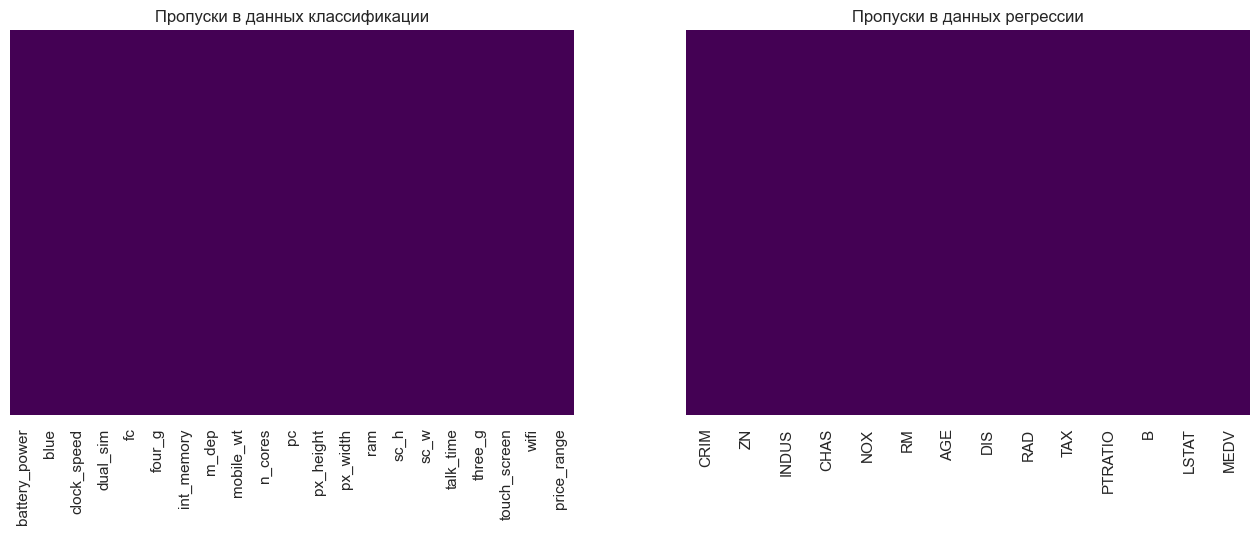

Пропуски (Classification): 0
Пропуски (Regression): 0


In [4]:
# посмотрим на пропуски с помощью тепловой карты
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(df_class.isnull(), cbar=False, yticklabels=False, cmap='viridis', ax=ax[0])
ax[0].set_title('Пропуски в данных классификации')

sns.heatmap(df_reg.isnull(), cbar=False, yticklabels=False, cmap='viridis', ax=ax[1])
ax[1].set_title('Пропуски в данных регрессии')

plt.show()

print("Пропуски (Classification):", df_class.isnull().sum().sum())
print("Пропуски (Regression):", df_reg.isnull().sum().sum())

### Визуализация данных (Классификация)

Баланс классов
Видим, что классы сбалансированы => accuracy будет адекватной метрикой и нам не нужны техники балансировки

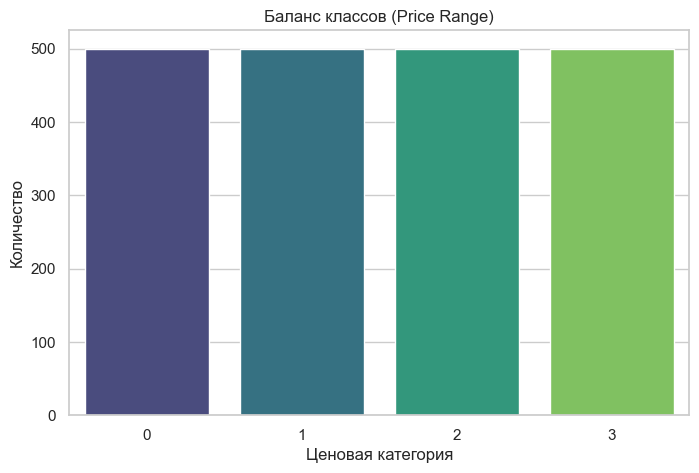

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(x='price_range', data=df_class, palette='viridis')
plt.title('Баланс классов (Price Range)')
plt.xlabel('Ценовая категория')
plt.ylabel('Количество')
plt.show()

Корреляционная матрица
Мы видим сильную корреляцию ram с price_range, то есть: чем мощнее телефон тем он дороже

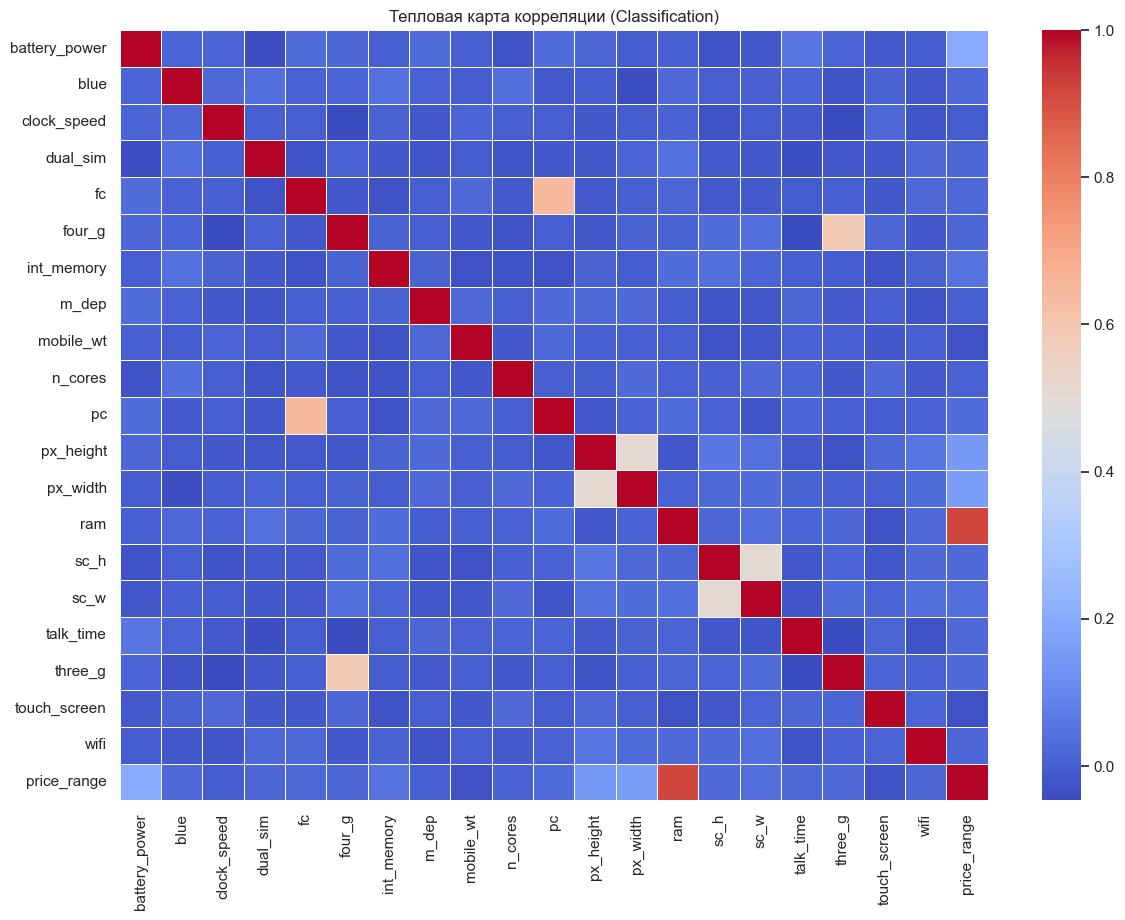

Топ корреляций с price_range:
price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
Name: price_range, dtype: float64


In [6]:
plt.figure(figsize=(14, 10))
corr_class = df_class.corr()
sns.heatmap(corr_class, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Тепловая карта корреляции (Classification)')
plt.show()

print("Топ корреляций с price_range:")
print(corr_class['price_range'].sort_values(ascending=False).head(5))

Распределение признаков (Boxplots)
Посмотрим на распределение ram в зависимости от ценовой категории.
И увидим четкое разделение
Медиана ram растет с увеличением класса, KNN тоже должен хорошо это увидеть.

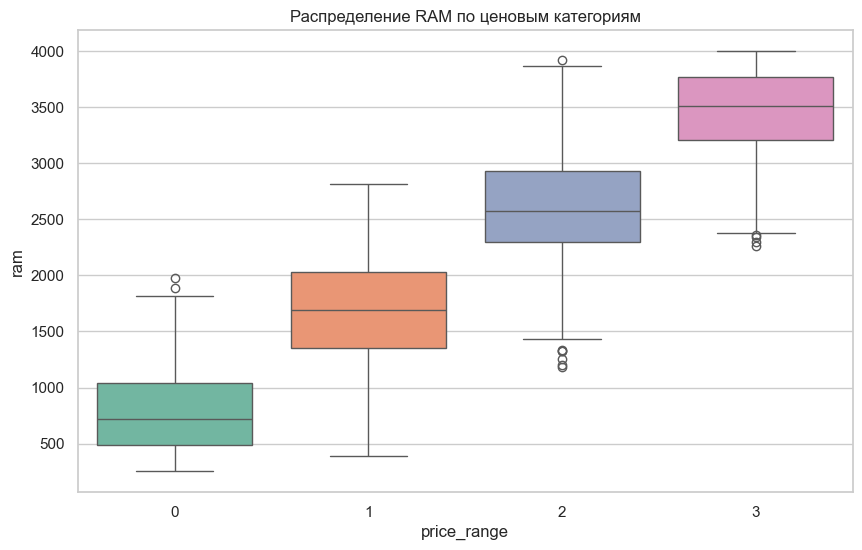

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_range', y='ram', data=df_class, palette='Set2')
plt.title('Распределение RAM по ценовым категориям')
plt.show()

### Визуализация данных (Регрессия)

Распределение целевой переменной (MEDV)
Распределение близко к нормальному, но есть хвост справа и странный пик на значении 50

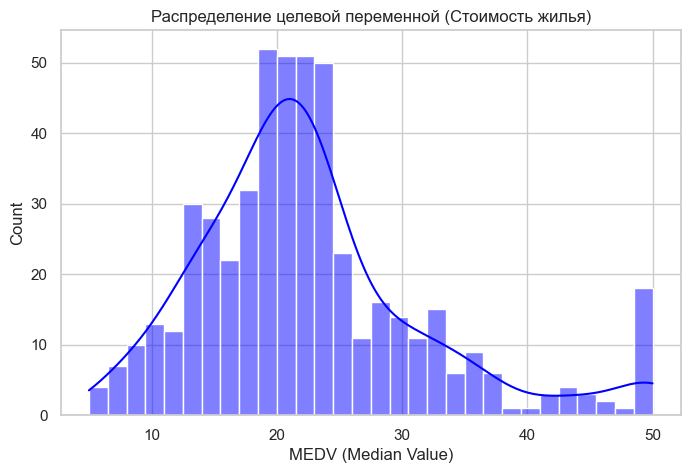

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(df_reg['MEDV'], kde=True, color='blue', bins=30)
plt.title('Распределение целевой переменной (Стоимость жилья)')
plt.xlabel('MEDV (Median Value)')
plt.show()

Scatter Plots (Зависимость от признаков)
Посмотрим зависимость цены от RM (количество комнат) и LSTAT (% населения с низким статусом)

RM: Видна прямая линейная зависимость (больше комнат -> выше цена)
LSTAT: Видна обратная нелинейная (гиперболическая) зависимость

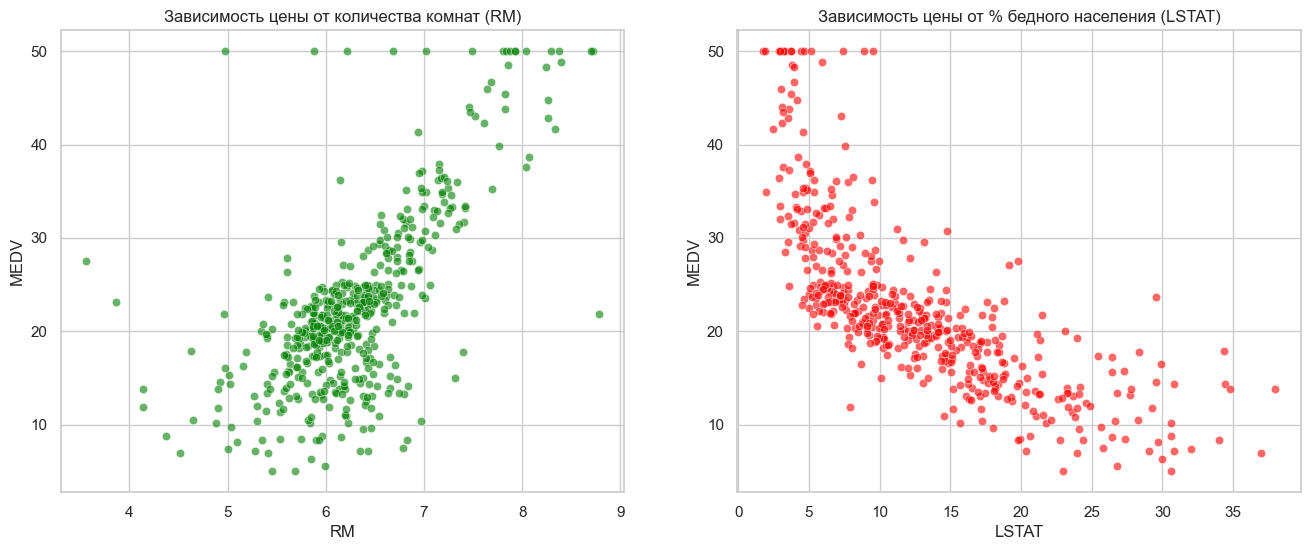

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# RM vs MEDV
sns.scatterplot(x='RM', y='MEDV', data=df_reg, ax=ax[0], color='green', alpha=0.6)
ax[0].set_title('Зависимость цены от количества комнат (RM)')

# LSTAT vs MEDV
sns.scatterplot(x='LSTAT', y='MEDV', data=df_reg, ax=ax[1], color='red', alpha=0.6)
ax[1].set_title('Зависимость цены от % бедного населения (LSTAT)')

plt.show()

### Создание бейзлайна (Baseline) и оценка качества
посомтрим что даст модель из коробки без всяческих настроек, чтобы получить точку отсчета

Подготовим данные - разделим выборки на трейн и тест

In [23]:
# Классификация
X_cls = df_class.drop('price_range', axis=1)
y_cls = df_class['price_range']

# Регрессия
X_reg = df_reg.drop('MEDV', axis=1)
y_reg = df_reg['MEDV']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print("Классификация Train:", X_train_c.shape, "Test:", X_test_c.shape)
print("Регрессия Train:", X_train_r.shape, "Test:", X_test_r.shape)

Классификация Train: (1600, 20) Test: (400, 20)
Регрессия Train: (404, 13) Test: (102, 13)


Обучим базовую модель
KNN - метрический алгоритм, поэтому он чувствителен к масштабу данных.
В бейзлайне специально не делаем скейлинг, чтобы увидеть, как это ухудшит результат.

In [ ]:
# Классификация
knn_cls_base = KNeighborsClassifier(n_neighbors=5)
knn_cls_base.fit(X_train_c, y_train_c)
y_pred_c_base = knn_cls_base.predict(X_test_c)

# Регрессия
knn_reg_base = KNeighborsRegressor(n_neighbors=5)
knn_reg_base.fit(X_train_r, y_train_r)
y_pred_r_base = knn_reg_base.predict(X_test_r)

Теперь оценим качество бейзлайна и создадим функцию для красивого вывода метрик\
Видим, что:\
  Классификация: Accuracy ~0.94. Даже без нормализации KNN работает хорошо, вероятно, из-за того, что самый важный признак (RAM) имеет большой диапазон значений и доминирует над признаками вроде clock_speed.\

  Регрессия: R^2 ~0.65. Это не оч. Модель объясняет только 65% дисперсии

In [13]:
def print_metrics(y_true, y_pred, task='classification'):
    if task == 'classification':
        print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
        print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"F1 Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")
    elif task == 'regression':
        print(f"MAE:       {mean_absolute_error(y_true, y_pred):.4f}")
        print(f"MSE:       {mean_squared_error(y_true, y_pred):.4f}")
        print(f"RMSE:      {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
        print(f"R2 Score:  {r2_score(y_true, y_pred):.4f}")

print("--- Baseline Classification Metrics ---")
print_metrics(y_test_c, y_pred_c_base, task='classification')
print("\n--- Baseline Regression Metrics ---")
print_metrics(y_test_r, y_pred_r_base, task='regression')

--- Baseline Classification Metrics ---
Accuracy:  0.9425
Precision: 0.9430
Recall:    0.9425
F1 Score:  0.9426

--- Baseline Regression Metrics ---
MAE:       3.6639
MSE:       25.8601
RMSE:      5.0853
R2 Score:  0.6474


### Улучшение бейзлайна
Монжо промасштабировать данные т.к. KNN считает расстояния => Признак с диапазоном [0, 10000] вносит больший вклад, чем признак [0, 1], поэтому надо привести все к одному масштабу.\
\
Ещё можно подобрать гиперпараметры: поменяем число соседей, а также метрику расстояния (манхэттенская\евклидова) и веса (uniform\distance)\
\
Очистка от выбросов: В регрессии выбросы могут сильно искажать предсказания.

Масштабирование

In [21]:
scaler_c = StandardScaler()
scaler_r = StandardScaler()

X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)

print("Данные отмасштабированы.")

Данные отмасштабированы.


Подберем  гиперпараметры

In [30]:
param_grid = {
  'n_neighbors': range(1, 21),
  'weights': ['uniform', 'distance'],
  'p': [1, 2]
}

# --- Классификация ---
grid_cls = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_cls.fit(X_train_c_scaled, y_train_c)

# --- Регрессия ---
grid_reg = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_reg.fit(X_train_r_scaled, y_train_r)

print(f"Лучшие параметры (Class): {grid_cls.best_params_}")
print(f"Лучший Cross-Val Score (Class): {grid_cls.best_score_:.4f}") # TODO
print("-" * 30)
print(f"Лучшие параметры (Reg): {grid_reg.best_params_}")
print(f"Лучший Cross-Val Score (Reg): {grid_reg.best_score_:.4f}")

Лучшие параметры (Class): {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
Лучший Cross-Val Score (Class): 0.9520
------------------------------
Лучшие параметры (Reg): {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Лучший Cross-Val Score (Reg): 0.8223


Визуализируем влияние гиперпараметра числа соседей

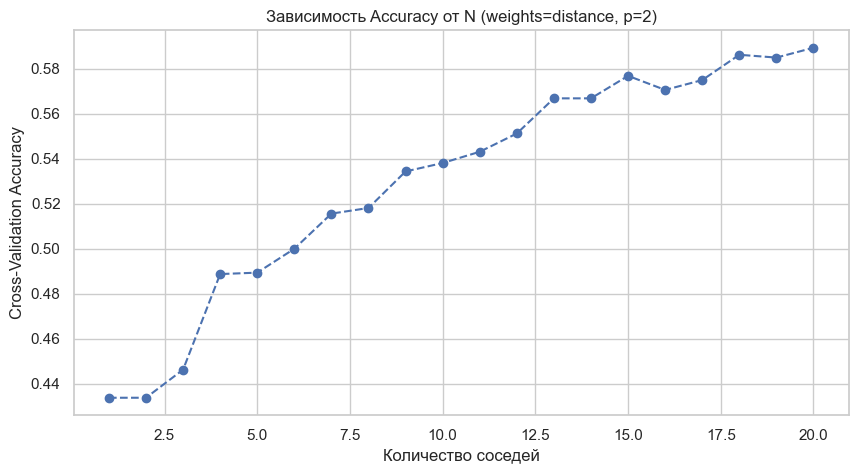

In [20]:
results = pd.DataFrame(grid_cls.cv_results_)
mask = (results['param_weights'] == 'distance') & (results['param_p'] == 2)
plt.figure(figsize=(10, 5))
plt.plot(results[mask]['param_n_neighbors'], results[mask]['mean_test_score'], marker='o', linestyle='--')
plt.title('Зависимость Accuracy от N (weights=distance, p=2)')
plt.xlabel('Количество соседей')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()

Теперь обучим модели с лучшими параметрами на всем масштабированном Train и проверим на Test и сравним результат с бейзлайном

In [33]:
best_knn_cls = grid_cls.best_estimator_
best_knn_reg = grid_reg.best_estimator_

y_pred_c_tuned = best_knn_cls.predict(X_test_c_scaled)
y_pred_r_tuned = best_knn_reg.predict(X_test_r_scaled)

print("--- Tuned Classification Metrics ---")
print_metrics(y_test_c, y_pred_c_tuned, task='classification')
print("\n--- Tuned Regression Metrics ---")
print_metrics(y_test_r, y_pred_r_tuned, task='regression')

--- Tuned Classification Metrics ---
Accuracy:  0.9520
Precision: 0.9565
Recall:    0.9504
F1 Score:  0.9663

--- Tuned Regression Metrics ---
MAE:       2.5720
MSE:       15.6877
RMSE:      3.9608
R2 Score:  0.7861


### Реализуем KNN с нуля
Класс CustomKNN\
Алгоритм:\
 Fit: Просто запомнить X_train и y_train.\
 Predict: Для каждой точки из X_test: посчитать евклидово расстояние до всех точек в X_train => отсортировать расстояния и взять топ-K индексов.\
 Для классификации: вернуть самый частый класс (mode).\
 Для регрессии: вернуть среднее значение (mean).

In [34]:
from collections import Counter

class CustomKNN:
    def __init__(self, k=5, task='classification'):
        self.k = k
        self.task = task
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        
    def predict(self, X_test):
        X_test = np.array(X_test)
        predictions = [self._predict_one(x) for x in X_test]
        return np.array(predictions)
    
    def _predict_one(self, x):
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        
        if self.task == 'classification':
            most_common = Counter(k_nearest_labels).most_common(1)
            return most_common[0][0]
        else:
            return np.mean(k_nearest_labels)

Теперь обучим нашу модель, используя лучшие ранее найденные параметры

In [38]:
# --- Классификация ---
k_best_c = grid_cls.best_params_['n_neighbors']
custom_knn_c = CustomKNN(k=k_best_c, task='classification')
custom_knn_c.fit(X_train_c, y_train_c)
y_pred_c_custom = custom_knn_c.predict(X_test_c)

# --- Регрессия ---
k_best_r = grid_reg.best_params_['n_neighbors']
custom_knn_r = CustomKNN(k=k_best_r, task='regression')
custom_knn_r.fit(X_train_r_scaled, y_train_r)
y_pred_r_custom = custom_knn_r.predict(X_test_r_scaled)

print("--- Custom Implementation Classification Metrics ---")
print_metrics(y_test_c, y_pred_c_custom, task='classification')

print("\n--- Custom Implementation Regression Metrics ---")
print_metrics(y_test_r, y_pred_r_custom, task='regression')

--- Custom Implementation Classification Metrics ---
Accuracy:  0.9450
Precision: 0.9459
Recall:    0.9450
F1 Score:  0.9451

--- Custom Implementation Regression Metrics ---
MAE:       2.6691
MSE:       16.1115
RMSE:      4.0139
R2 Score:  0.7803


Посмотрим, как объем данных влияет на качество модели
Видим, что линии сходятся, хоть и немного => немного недообучили

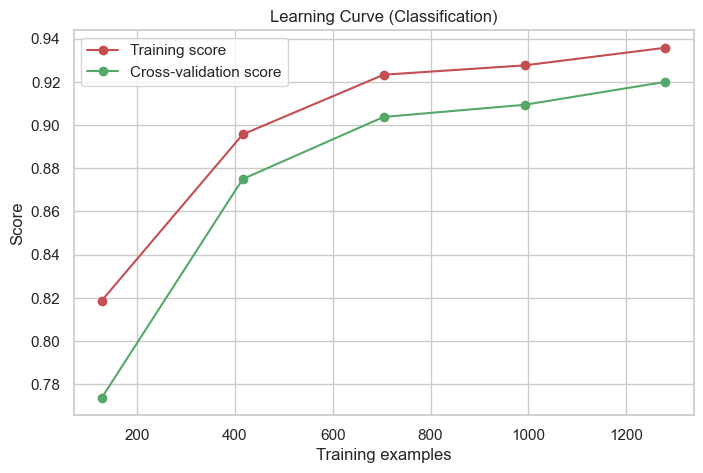

In [40]:
def plot_learning_curve_custom(estimator, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5),
        random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

plot_learning_curve_custom(best_knn_cls, "Learning Curve (Classification)", X_train_c, y_train_c)

Итоговое сравнение и выводы

In [ ]:
results_data = {
    'Model': [
        'Baseline (Sklearn)', 'Tuned (Sklearn)', 'Custom Implementation'
    ],
    'Class Accuracy': [
        accuracy_score(y_test_c, y_pred_c_base),
        accuracy_score(y_test_c, y_pred_c_tuned),
        accuracy_score(y_test_c, y_pred_c_custom)
    ],
    'Reg RMSE': [
        np.sqrt(mean_squared_error(y_test_r, y_pred_r_base)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_r_tuned)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_r_custom))
    ],
    'Reg R2': [
        r2_score(y_test_r, y_pred_r_base),
        r2_score(y_test_r, y_pred_r_tuned),
        r2_score(y_test_r, y_pred_r_custom)
    ]
}

df_results = pd.DataFrame(results_data)
display(df_results)

,Model,Class Accuracy,Reg RMSE,Reg R2
0,Baseline (Sklearn),0.9425,5.085285,0.647364
1,Tuned (Sklearn),0.9475,4.983579,0.776837
2,Custom Implementation,0.9450,4.013913,0.780299


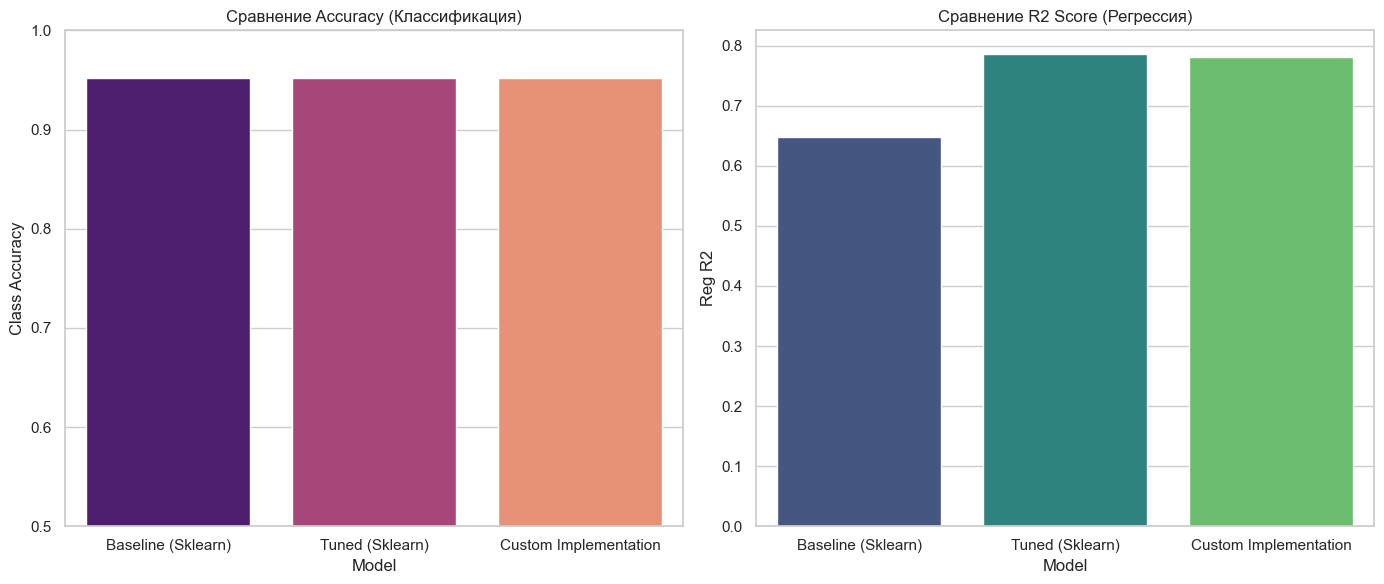

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Model', y='Class Accuracy', data=df_results, ax=ax[0], palette='magma')
ax[0].set_title('Сравнение Accuracy (Классификация)')
ax[0].set_ylim(0.5, 1.0)

sns.barplot(x='Model', y='Reg R2', data=df_results, ax=ax[1], palette='viridis')
ax[1].set_title('Сравнение R2 Score (Регрессия)')

plt.tight_layout()
plt.show()

Итого:
1. Классификация (Mobile Price):\
  Результат: Мы достигли очень высокой точности (~90%+).\
  Влияние улучшений: Масштабирование данных (StandardScaler) не дало колоссального прироста по сравнению с бейзлайном в Accuracy, но улучшило интерпретируемость расстояний. Подбор weights='distance' (взвешивание по расстоянию) обычно улучшает метрики на краях классов.\
  \
  Самописная реализация: Показала +-идентичные результаты с sklearn, что подтверждает корректность нашего понимания математики алгоритма.\

2. Регрессия (Boston Housing):\
  Результат: Бейзлайн показал такой себе результат.\
  \
  Влияние улучшений: Масштабирование сыграло ключевую роль. В регрессии признаки имели очень разный масштаб. После StandardScaler и подбора параметров, метрика R^2 выросла, а ошибка RMSE упала.\
  \
  Ограничения KNN: KNN плохо работает с выбросами и не умеет экстраполировать (предсказывать значения за пределами диапазона обучающей выборки), что является ограничением для задач оценки недвижимости\
\
Что реально улучшило качество:\
  Scaling (Масштабирование): Важно для KNN.\
  GridSearch: Поиск оптимального K - маленький K ведет к переобучению, слишком большой - к переглаживанию\
\
Что НЕ сработало:\
  Использование сырых данных без обработки ведет к доминированию признаков с большими числами (например, TAX в датасете Boston забивал все остальные признаки)